In [7]:
# Import required modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply, Lambda

In [8]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')


In [9]:

# Separate input features (first 4 columns) and output (5th column)
X = data.iloc[:, :5].values  # First 4 columns as input features
y = data.iloc[:, 5].values   # 5th column as output

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [10]:
# Split into curvature and error groups
cCols = ["curvature", "lookAhead1"]
cCols = [1, 3]
X_train_c = X_train[:, cCols]
X_val_c = X_val[:, cCols]
X_test_c = X_test[:, cCols]

eCols = ["CTE", "Heading Error"]
eCols = [0, 2]
X_train_e = X_train[:, eCols]
X_val_e = X_val[:, eCols]
X_test_e = X_test[:, eCols]

In [13]:
# Define input layers
curvature_input = Input(shape=(2,), name="Curvature_LA_Curvature")  # Primary Features
error_input = Input(shape=(2,), name="CTE_HE")  # Correction Features

# Primary steering decision (based on track curvature)
curvature_layer = Dense(16, activation="relu")(curvature_input)
curvature_layer = Dense(8, activation="relu")(curvature_layer)

# Correction-based steering adjustments
error_layer = Dense(8, activation="relu")(error_input)
error_layer = Dense(4, activation="relu")(error_layer)

# Ensure shape compatibility before multiplication
curvature_layer = Dense(4, activation="relu")(curvature_layer)  # Match size with error_layer

# Introduce learnable scaling weights
curvature_weight = tf.Variable(1.0, trainable=True, dtype=tf.float32, name="Curvature_Weight")
error_weight = tf.Variable(0.8, trainable=True, dtype=tf.float32, name="Error_Weight")

# Convert scalar weights into tensors with same shape as inputs
curvature_weight_tensor = Lambda(lambda x: x * curvature_weight)(curvature_layer)
error_weight_tensor = Lambda(lambda x: x * error_weight)(error_layer)

# Merge both processed features
merged = Concatenate()([curvature_weight_tensor, error_weight_tensor])

# Final output layer
output_layer = Dense(1, activation="linear", name="Steering")(merged)

# Define model
model = Model(inputs=[curvature_input, error_input], outputs=output_layer)

In [14]:
# Start the timer
start_time = time.time()

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    [X_train_c, X_train_e], y_train,
    validation_data=([X_val_c, X_val_e], y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Curvature_LA_Curva… │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │         48 │ Curvature_LA_Cur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CTE_HE (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 8)         │        136 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 8)         │         24 │ CTE_HE[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 4)         │         36 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4)         │         36 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 4)         │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 4)         │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8)         │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Steering (Dense)    │ (None, 1)         │          9 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0058 - mae: 0.0366 - val_loss: 0.0015 - val_mae: 0.0250
Epoch 2/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0015 - mae: 0.0250 - val_loss: 0.0014 - val_mae: 0.0247
Epoch 3/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0014 - mae: 0.0248 - val_loss: 0.0014 - val_mae: 0.0245
Epoch 4/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 0.0014 - val_mae: 0.0243
Epoch 5/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0014 - mae: 0.0246 - val_loss: 0.0014 - val_mae: 0.0242
Epoch 6/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0014 - mae: 0.0245 - val_loss: 0.0014 - val_mae: 0.0242
Epoch 7/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0014 - mae: 0.0245 - val_loss: 0.0014 - val_mae: 0.0241
Epoch 8/50
15127/15127 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0014 - mae: 0.0245 - val_loss: 0.0014 - val_mae: 0.0241
Epoch 9/50
15127

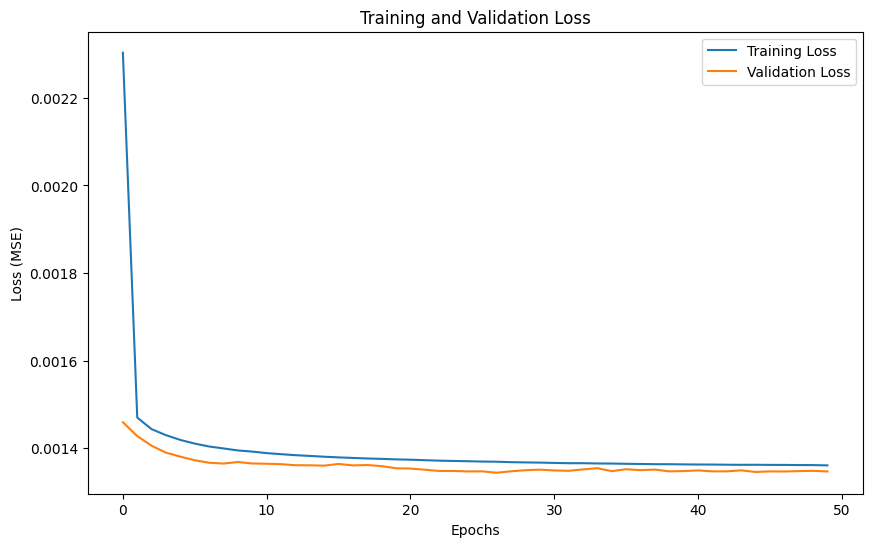

3242/3242 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


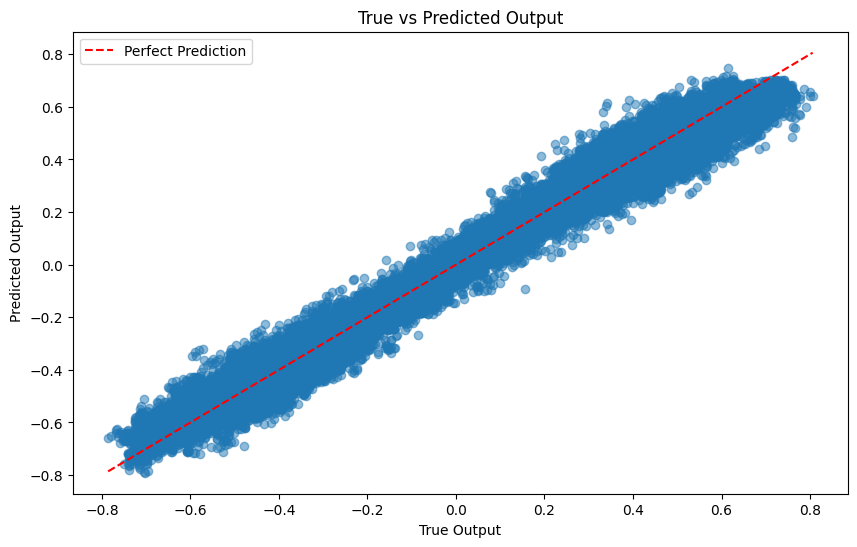

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Predict on test set and visualize results
y_pred = model.predict([X_test_c, X_test_e])
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Output')
plt.xlabel('True Output')
plt.ylabel('Predicted Output')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

In [16]:
# Export the model
model.export("SteeringModel_Iteration69")

INFO:tensorflow:Assets written to: SteeringModel_Iteration69\assets


INFO:tensorflow:Assets written to: SteeringModel_Iteration69\assets


Saved artifact at 'SteeringModel_Iteration69'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2), dtype=tf.float32, name='Curvature_LA_Curvature'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='CTE_HE')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1587569915280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587569916624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587569911056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587532039568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587569917584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587569916432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587532039760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587532040336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587532040528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1587532041104: TensorSpec

In [ ]:
# Extract the specific weights by filtering their names
curvature_weight_value = None
error_weight_value = None

for var in model.trainable_variables:
    if "curvature_weight" in var.name.lower():
        curvature_weight_value = var.numpy()
    elif "error_weight" in var.name.lower():
        error_weight_value = var.numpy()

# Print the found values
print("Learned Curvature Weight:", curvature_weight_value)
print("Learned Error Weight:", error_weight_value)


kernel: [[ 0.9689647   0.09005022  0.69609374  0.5422584  -0.26121682 -1.0090587
  -0.56886226 -0.08507939  0.13872117  0.8092002   0.03911102 -0.7500584
   0.92658013 -1.1325955  -0.24537425 -0.4274447 ]
 [-0.7052659  -0.64083517 -1.1197618  -0.37127617  0.13612303  0.20920227
  -0.28413442  0.76723045 -1.0411193  -0.0186077  -0.79008514  0.7316673
  -0.6962178   0.10775412  0.40318072  1.1951798 ]]
bias: [-0.55508786  0.05462648 -0.9523309   0.08627635  0.09647733 -0.27688342
 -0.33284384 -0.96445924 -1.0944649   0.14565797 -0.4604191   0.09000786
 -0.8815231   0.13216238 -0.01597032 -0.8508352 ]
kernel: [[ 5.19437969e-01  7.41499484e-01  6.64930105e-01 -1.26748025e+00
  -4.21274394e-01  1.10178733e+00  2.07106266e-02  1.20366693e+00]
 [-1.06201684e+00 -2.94885665e-01 -1.67688417e+00  8.91245604e-02
  -4.65506941e-01 -2.10566297e-01 -2.32687545e+00 -1.74116164e-01]
 [ 9.44819450e-01  2.00100923e+00 -5.71874559e-01 -1.31921160e+00
  -6.60699606e-02  1.81951880e+00  1.40565443e+00  1.5

In [36]:
# Feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, [X_test_c, X_test_e], y_test, scoring='neg_mean_absolute_error')
feature_importance = result.importances_mean
print("Feature Importance:", feature_importance)

ValueError: Found array with dim 3. None expected <= 2.

In [17]:
from tensorflow.keras.utils import plot_model

# Generate and save the model architecture visualization
plot_model(model, show_shapes=True, show_layer_names=True, to_file="ffnn_hierarchy.png")

print("Model visualization saved as ffnn_hierarchy.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model visualization saved as ffnn_hierarchy.png
